In [14]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import read_structure, molecule
from matplotlib import pyplot as plt
import numpy as np
from pennylane import commutator

import numpy as np

symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.74]  # unit Å
])


H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, active_electrons=2, active_orbitals=2)
print(" qubits number:", qubits)

dev = qml.device("default.qubit", wires=qubits)
from pennylane import qchem

H_c, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    method='pyscf',
    basis='sto-3g'
)
print(H_c)

def build_driver_h(n):
    coeffs = [-1.0] * n
    ops = [qml.PauliX(i) for i in range(n)]
    return qml.Hamiltonian(coeffs, ops)

driver_h = build_driver_h(qubits)
print(driver_h)

def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []

    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()

    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                # check no commute term
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue  
                
                # multiply j
                comm_terms.append(1j * c1 * c2 * comm)

            except Exception as e:
                print(f"跳过某个项：[{op1}, {op2}] 计算 commutator 出错，原因：{e}")
                continue

    if len(comm_terms) == 0:
        print("所有 commutators 都是 0")
        return qml.Hamiltonian([], [])
    
    # 合并所有项
    full_comm = sum(comm_terms)
    return full_comm.simplify()

comm_h=build_commutator_hamiltonian(driver_h,H_c)
print(comm_h)

def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    qml.ApproxTimeEvolution(driver_h, beta_k * delta_t, 1)

# 7. build ansatz（多层 feedback 演化）
def build_ansatz(cost_h, driver_h, delta_t):
    def ansatz(beta, **kwargs):
        for w in dev.wires:
            qml.Hadamard(wires=w)  # 初始化为 |+⟩

        if len(beta) > 1:
            
            qml.layer(falqon_layer, len(beta) - 1, beta[:-1],
                      cost_h=cost_h, driver_h=driver_h, delta_t=delta_t)
        
        
        falqon_layer(beta[-1], cost_h, driver_h, delta_t)
        
    return ansatz



def expval_circuit(beta, measurement_h):
    ansatz = build_ansatz(H, driver_h, delta_t)
    ansatz(beta)
    return qml.expval(measurement_h)

# 9. 主过程：运行 FBQA，生成 β 序列与能量估计
def run_fbqa(H, driver_h, comm_h, n_steps, beta_1, delta_t):
    beta_list = [beta_1]
    energy_list = []

    cost_fn = qml.QNode(expval_circuit, dev, interface="autograd")

    for i in range(n_steps):
        # 用 commutator 哈密顿量测量当前态，得到下一层 feedback 参数
        next_beta = -delta_t * cost_fn(beta_list, measurement_h=comm_h)
        beta_list.append(next_beta)

        # 计算当前 ansatz 态的能量期望
        energy = cost_fn(beta_list, measurement_h=H)
        energy_list.append(energy)
        print(f"第 {i+1} 步: E = {energy:.8f} Ha, β_{i+1} = {next_beta:.6f}")

    return beta_list, energy_list

# 10. 参数设定并运行
n_steps = 100
delta_t = 0.1
beta_1 = 0.0

res_beta, res_energies = run_fbqa(H, driver_h, comm_h, n_steps, beta_1, delta_t)

plt.plot(range(1, n_steps + 1), res_energies)
plt.xlabel("iteration number")
plt.ylabel("approximate energy (Hartree)")
plt.title("FBQA approximate Hydrogen molecule ground state energy")
plt.grid(True)
plt.tight_layout()
plt.show()

 qubits number: 4
0.7784107703315544 * I([0, 2, 1, 3]) + 0.23718739979583803 * Z(0) + -0.4612495808843312 * Z(2) + 0.1406570062079997 * (Z(0) @ Z(2)) + 0.23718739979583803 * Z(1) + 0.18456105273155665 * (Z(0) @ Z(1)) + 0.04104417944033013 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04104417944033013 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04104417944033013 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04104417944033013 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.4612495808843312 * Z(3) + 0.18170118564832982 * (Z(0) @ Z(3)) + 0.1406570062079997 * (Z(1) @ Z(3)) + 0.18170118564832982 * (Z(1) @ Z(2)) + 0.1917875067959805 * (Z(2) @ Z(3))
-1.0 * X(0) + -1.0 * X(1) + -1.0 * X(2) + -1.0 * X(3)
(-0.47437479959167606+0j) * Y(0) + (-0.2813140124159994+0j) * (Y(0) @ Z(2)) + (-0.3691221054631133+0j) * (Y(0) @ Z(1)) + (0.08208835888066025+0j) * (Z(0) @ X(1) @ X(2) @ Y(3)) + (-0.08208835888066025+0j) * (Z(0) @ Y(1) @ X(2) @ X(3)) + (-0.36340237129665964+0j) * (Y(0) @ Z(3)) + (-0.47437479959167606+0j) * Y(1) + (-0.3691221054631133+0j) 

KeyboardInterrupt: 

qubits number: 4
0.7784107703315544 * I([0, 2, 1, 3]) + 0.23718739979583803 * Z(0) + -0.4612495808843312 * Z(2) + 0.1406570062079997 * (Z(0) @ Z(2)) + 0.23718739979583803 * Z(1) + 0.18456105273155665 * (Z(0) @ Z(1)) + 0.04104417944033013 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04104417944033013 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04104417944033013 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04104417944033013 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.4612495808843312 * Z(3) + 0.18170118564832982 * (Z(0) @ Z(3)) + 0.1406570062079997 * (Z(1) @ Z(3)) + 0.18170118564832982 * (Z(1) @ Z(2)) + 0.1917875067959805 * (Z(2) @ Z(3))
-1.0 * X(0) + -1.0 * X(1) + -1.0 * X(2) + -1.0 * X(3)
(-0.47437479959167606+0j) * Y(0) + (-0.2813140124159994+0j) * (Y(0) @ Z(2)) + (-0.3691221054631133+0j) * (Y(0) @ Z(1)) + (0.08208835888066025+0j) * (Z(0) @ X(1) @ X(2) @ Y(3)) + (-0.08208835888066025+0j) * (Z(0) @ Y(1) @ X(2) @ X(3)) + (-0.36340237129665964+0j) * (Y(0) @ Z(3)) + (-0.47437479959167606+0j) * Y(1) + (-0.3691221054631133+0j) *

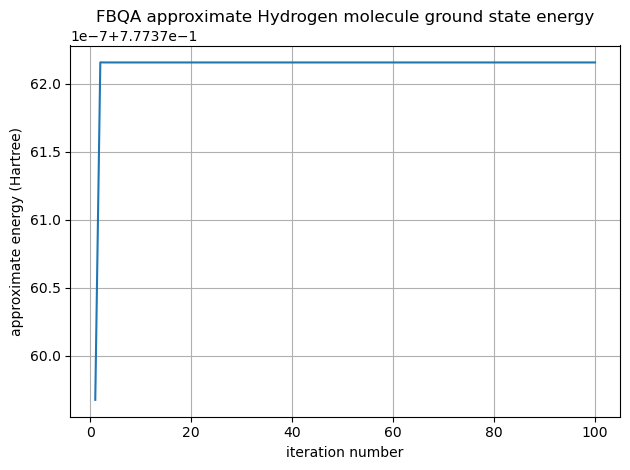

In [15]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import read_structure, molecule
from matplotlib import pyplot as plt
from pennylane import commutator

# 1. 定义分子结构
symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.74]  # 单位：Å
])

# 2. 获取分子哈密顿量
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, active_electrons=2, active_orbitals=2)
print("qubits number:", qubits)

dev = qml.device("default.qubit", wires=qubits)

# 3. 使用 PySCF 精确计算分子哈密顿量
from pennylane import qchem
H_c, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    method='pyscf',
    basis='sto-3g'
)
print(H_c)

# 4. 构造 Driver Hamiltonian（PauliX 和 -1 系数）
def build_driver_h(n):
    coeffs = [-1.0] * n
    ops = [qml.PauliX(i) for i in range(n)]
    return qml.Hamiltonian(coeffs, ops)

driver_h = build_driver_h(qubits)
print(driver_h)

# 5. 构造 commutator 哈密顿量 [Hd, Hc]
def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []

    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()

    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue
                comm_terms.append(1j * c1 * c2 * comm)
            except Exception as e:
                print(f"跳过某个项：[{op1}, {op2}] 计算 commutator 出错，原因：{e}")
                continue

    if len(comm_terms) == 0:
        print("所有 commutators 都是 0")
        return qml.Hamiltonian([], [])

    full_comm = sum(comm_terms)
    return full_comm.simplify()

comm_h = build_commutator_hamiltonian(driver_h, H_c)
print(comm_h)

# 6. 单层 FALQON：cost 演化 + driver 演化
def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    qml.ApproxTimeEvolution(driver_h, beta_k * delta_t, 1)

# 7. 构造单层 Ansatz
def single_layer_ansatz(beta_k, cost_h, driver_h, delta_t):
    for w in dev.wires:
        qml.Hadamard(wires=w)  # 初始化为 |+>
    falqon_layer(beta_k, cost_h, driver_h, delta_t)

# 8. 期望值测量电路（每轮只测一层）
def expval_single_layer(beta_k, measurement_h):
    single_layer_ansatz(beta_k, H, driver_h, delta_t)
    return qml.expval(measurement_h)

# 9. 主过程：运行 FALQON，生成 β 序列与能量估计
def run_fbqa_light(H, driver_h, comm_h, n_steps, beta_1, delta_t):
    beta_list = [beta_1]
    energy_list = []

    cost_fn = qml.QNode(expval_single_layer, dev, interface="autograd")

    for i in range(n_steps):
        current_beta = beta_list[-1]

        # 计算 feedback beta：使用 commutator 哈密顿量
        next_beta = -delta_t * cost_fn(current_beta, measurement_h=comm_h)
        beta_list.append(next_beta)

        # 计算当前状态能量
        energy = cost_fn(next_beta, measurement_h=H)
        energy_list.append(energy)

        print(f"第 {i+1} 步: E = {energy:.8f} Ha, β_{i+1} = {next_beta:.6f}")

    return beta_list, energy_list

# 10. 参数设定并运行
n_steps = 100
delta_t = 0.1
beta_1 = 0.0

res_beta, res_energies = run_fbqa_light(H, driver_h, comm_h, n_steps, beta_1, delta_t)

# 11. 绘图展示
plt.plot(range(1, n_steps + 1), res_energies)
plt.xlabel("iteration number")
plt.ylabel("approximate energy (Hartree)")
plt.title("FBQA approximate Hydrogen molecule ground state energy")
plt.grid(True)
plt.tight_layout()
plt.show()


qubits number: 4
Cost Hamiltonian (H_c):
 0.7784107703315544 * I([0, 2, 1, 3]) + 0.23718739979583803 * Z(0) + -0.4612495808843312 * Z(2) + 0.1406570062079997 * (Z(0) @ Z(2)) + 0.23718739979583803 * Z(1) + 0.18456105273155665 * (Z(0) @ Z(1)) + 0.04104417944033013 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04104417944033013 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04104417944033013 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04104417944033013 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.4612495808843312 * Z(3) + 0.18170118564832982 * (Z(0) @ Z(3)) + 0.1406570062079997 * (Z(1) @ Z(3)) + 0.18170118564832982 * (Z(1) @ Z(2)) + 0.1917875067959805 * (Z(2) @ Z(3))
Driver Hamiltonian:
 -1.0 * X(0) + -1.0 * X(1) + -1.0 * X(2) + -1.0 * X(3)
Commutator Hamiltonian:
 (-0.47437479959167606+0j) * Y(0) + (-0.2813140124159994+0j) * (Y(0) @ Z(2)) + (-0.3691221054631133+0j) * (Y(0) @ Z(1)) + (0.08208835888066025+0j) * (Z(0) @ X(1) @ X(2) @ Y(3)) + (-0.08208835888066025+0j) * (Z(0) @ Y(1) @ X(2) @ X(3)) + (-0.36340237129665964+0j) * (Y(0) 

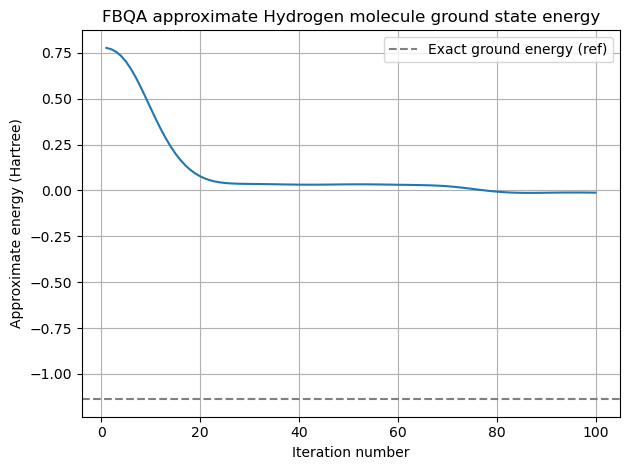

In [16]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
from matplotlib import pyplot as plt

# 1. 分子结构定义
symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.74]  # 单位：Å
])

# 2. 构造分子哈密顿量
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, active_electrons=2, active_orbitals=2)
print("qubits number:", qubits)

dev = qml.device("default.qubit", wires=qubits)

# 使用 PySCF 获取更加精确的 cost Hamiltonian
H_c, qubits = qml.qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    method='pyscf',
    basis='sto-3g'
)
print("Cost Hamiltonian (H_c):\n", H_c)

# 3. 构建 Driver Hamiltonian（X项叠加）
def build_driver_h(n):
    coeffs = [-1.0] * n
    ops = [qml.PauliX(i) for i in range(n)]
    return qml.Hamiltonian(coeffs, ops)

driver_h = build_driver_h(qubits)
print("Driver Hamiltonian:\n", driver_h)

# 4. 构造 commutator 哈密顿量 [Hd, Hc]
def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []
    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()

    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue
                comm_terms.append(1j * c1 * c2 * comm)
            except Exception as e:
                print(f"跳过 [{op1}, {op2}]：{e}")
                continue

    if not comm_terms:
        print("所有 commutators 都是 0")
        return qml.Hamiltonian([], [])

    full_comm = sum(comm_terms)
    return full_comm.simplify()

comm_h = build_commutator_hamiltonian(driver_h, H_c)
print("Commutator Hamiltonian:\n", comm_h)

# 5. 单层 FALQON：cost + driver
def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    qml.ApproxTimeEvolution(driver_h, beta_k * delta_t, 1)

# 6. 多层 ansatz 构建（保留历史 β 演化）
def build_ansatz(cost_h, driver_h, delta_t):
    def ansatz(beta, **kwargs):
        for w in dev.wires:
            qml.Hadamard(wires=w)
        for beta_k in beta:
            falqon_layer(beta_k, cost_h, driver_h, delta_t)
    return ansatz

# 7. 期望值电路
def expval_circuit(beta, measurement_h):
    ansatz = build_ansatz(H, driver_h, delta_t)
    ansatz(beta)
    return qml.expval(measurement_h)

# 8. 主过程：运行 FBQA
def run_fbqa(H, driver_h, comm_h, n_steps, beta_1, delta_t):
    beta_list = [beta_1]
    energy_list = []

    cost_fn = qml.QNode(expval_circuit, dev, interface="autograd")

    for i in range(n_steps):
        next_beta = -delta_t * cost_fn(beta_list, measurement_h=comm_h)
        beta_list.append(next_beta)

        energy = cost_fn(beta_list, measurement_h=H)
        energy_list.append(energy)

        print(f"第 {i+1} 步: E = {energy:.8f} Ha, β_{i+1} = {next_beta:.6f}")

    return beta_list, energy_list

# 9. 设置参数并运行
n_steps = 100
delta_t = 0.1
beta_1 = 0.0

res_beta, res_energies = run_fbqa(H, driver_h, comm_h, n_steps, beta_1, delta_t)

# 10. 绘图展示
plt.plot(range(1, n_steps + 1), res_energies)
plt.xlabel("Iteration number")
plt.ylabel("Approximate energy (Hartree)")
plt.title("FBQA approximate Hydrogen molecule ground state energy")
plt.axhline(y=-1.1373, linestyle="--", color="gray", label="Exact ground energy (ref)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Qubits: 4
第 1 步: E = 0.77868178 Ha, β_1 = -0.000000
第 2 步: E = 0.77634948 Ha, β_2 = 0.036137
第 3 步: E = 0.76901964 Ha, β_3 = 0.071539
第 4 步: E = 0.75472714 Ha, β_4 = 0.105414
第 5 步: E = 0.73213698 Ha, β_5 = 0.136929
第 6 步: E = 0.70069816 Ha, β_6 = 0.165248
第 7 步: E = 0.66071397 Ha, β_7 = 0.189598
第 8 步: E = 0.61330046 Ha, β_8 = 0.209341
第 9 步: E = 0.56022756 Ha, β_9 = 0.224058
第 10 步: E = 0.50366834 Ha, β_10 = 0.233598
第 11 步: E = 0.44590862 Ha, β_11 = 0.238099
第 12 步: E = 0.38907866 Ha, β_12 = 0.237963
第 13 步: E = 0.33495652 Ha, β_13 = 0.233787
第 14 步: E = 0.28486569 Ha, β_14 = 0.226279
第 15 步: E = 0.23966118 Ha, β_15 = 0.216173
第 16 步: E = 0.19977873 Ha, β_16 = 0.204153
第 17 步: E = 0.16531666 Ha, β_17 = 0.190812
第 18 步: E = 0.13612445 Ha, β_18 = 0.176634
第 19 步: E = 0.11188165 Ha, β_19 = 0.161996
第 20 步: E = 0.09216031 Ha, β_20 = 0.147184
第 21 步: E = 0.07647057 Ha, β_21 = 0.132422
第 22 步: E = 0.06429277 Ha, β_22 = 0.117887
第 23 步: E = 0.05510032 Ha, β_23 = 0.103737
第 24 步: E = 0.0483

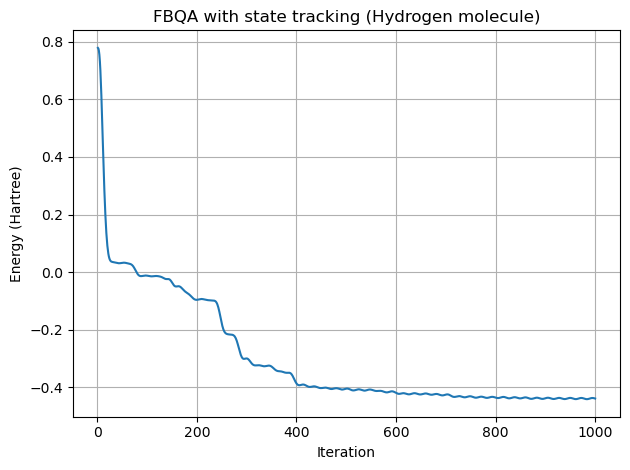

In [18]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
import matplotlib.pyplot as plt

# 1. 设置分子结构
symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.74]])  # 单位 Å

# 2. 分子哈密顿量（cost Hamiltonian）
H_c, qubits = qml.qchem.molecular_hamiltonian(
    symbols, coordinates, method='pyscf', basis='sto-3g'
)
print("Qubits:", qubits)

# 3. Driver Hamiltonian
def build_driver_h(n):
    return qml.Hamiltonian([-1.0] * n, [qml.PauliX(i) for i in range(n)])

driver_h = build_driver_h(qubits)

# 4. 构造 commutator 哈密顿量
def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []
    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()
    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue
                comm_terms.append(1j * c1 * c2 * comm)
            except Exception as e:
                print(f"跳过 [{op1}, {op2}]：{e}")
                continue
    return sum(comm_terms).simplify()

comm_h = build_commutator_hamiltonian(driver_h, H_c)

# 5. 初始化量子态：|+>^n
dev = qml.device("default.qubit", wires=qubits)
@qml.qnode(dev)
def plus_state():
    for w in range(qubits):
        qml.Hadamard(w)
    return qml.state()

# 6. 单步 FALQON 演化矩阵
def single_falqon_unitary(beta_k, delta_t, cost_h, driver_h):
    U_cost = qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    U_driver = qml.ApproxTimeEvolution(driver_h, beta_k * delta_t, 1)
    return qml.matrix(U_driver @ U_cost, wire_order=range(qubits))

# 7. 测量期望值 ⟨ψ|H|ψ⟩
def measure_expectation(state, H):
    H_mat = qml.matrix(H, wire_order=range(qubits))
    return np.real(np.vdot(state, H_mat @ state))

# 8. 主流程：状态保留式 FALQON
def run_fbqa_state_tracking(H, driver_h, comm_h, n_steps, beta_1, delta_t):
    beta_list = [beta_1]
    energy_list = []

    state = plus_state()

    for i in range(n_steps):
        # 计算 feedback beta
        exp_comm = measure_expectation(state, comm_h)
        next_beta = -delta_t * exp_comm
        beta_list.append(next_beta)

        # 应用下一步 unitary
        U_k = single_falqon_unitary(next_beta, delta_t, H, driver_h)
        state = U_k @ state

        # 计算能量
        energy = measure_expectation(state, H)
        energy_list.append(energy)

        print(f"第 {i+1} 步: E = {energy:.8f} Ha, β_{i+1} = {next_beta:.6f}")

    return beta_list, energy_list

# 9. 设置参数并运行
n_steps = 1000
delta_t = 0.1
beta_1 = 0.0

res_beta, res_energies = run_fbqa_state_tracking(H_c, driver_h, comm_h, n_steps, beta_1, delta_t)

# 10. 可视化
plt.plot(range(1, n_steps + 1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Energy (Hartree)")
plt.title("FBQA with state tracking (Hydrogen molecule)")
plt.grid(True)
plt.tight_layout()
plt.show()
